In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
pd.set_option('display.max_colwidth',300)

In [2]:
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
import numpy as np
def classification_metrics(y_true, y_pred, label='',
                           output_dict=False, figsize=(8,4),
                           normalize='true', cmap='Blues',
                           colorbar=False,values_format=".2f"):
    """Modified version of classification metrics function from Intro to Machine Learning.
    Updates:
    - Reversed raw counts confusion matrix cmap  (so darker==more).
    - Added arg for normalized confusion matrix values_format
    """
    # Get the classification report
    report = classification_report(y_true, y_pred)
    
    ## Print header and report
    header = "-"*70
    print(header, f" Classification Metrics: {label}", header, sep='\n')
    print(report)
    
    ## CONFUSION MATRICES SUBPLOTS
    fig, axes = plt.subplots(ncols=2, figsize=figsize)
    
    # Create a confusion matrix  of raw counts (left subplot)
    ConfusionMatrixDisplay.from_predictions(y_true, y_pred,
                                            normalize=None, 
                                            cmap='gist_gray_r',# Updated cmap
                                            values_format="d", 
                                            colorbar=colorbar,
                                            ax = axes[0]);
    axes[0].set_title("Raw Counts")
    
    # Create a confusion matrix with the data with normalize argument 
    ConfusionMatrixDisplay.from_predictions(y_true, y_pred,
                                            normalize=normalize,
                                            cmap=cmap, 
                                            values_format=values_format, #New arg
                                            colorbar=colorbar,
                                            ax = axes[1]);
    axes[1].set_title("Normalized Confusion Matrix")
    
    # Adjust layout and show figure
    fig.tight_layout()
    plt.show()
    
    # Return dictionary of classification_report
    if output_dict==True:
        report_dict = classification_report(y_true, y_pred, output_dict=True)
        return report_dict
    
    
def evaluate_classification(model, X_train, y_train, X_test, y_test,
                         figsize=(6,4), normalize='true', output_dict = False,
                            cmap_train='Blues', cmap_test="Reds",colorbar=False):
  # Get predictions for training data
  y_train_pred = model.predict(X_train)
  # Call the helper function to obtain regression metrics for training data
  results_train = classification_metrics(y_train, y_train_pred, #verbose = verbose,
                                     output_dict=True, figsize=figsize,
                                         colorbar=colorbar, cmap=cmap_train,
                                     label='Training Data')
  print()
  # Get predictions for test data
  y_test_pred = model.predict(X_test)
  # Call the helper function to obtain regression metrics for test data
  results_test = classification_metrics(y_test, y_test_pred, #verbose = verbose,
                                  output_dict=True,figsize=figsize,
                                         colorbar=colorbar, cmap=cmap_test,
                                    label='Test Data' )
  if output_dict == True:
    # Store results in a dataframe if ouput_frame is True
    results_dict = {'train':results_train,
                    'test': results_test}
    return results_dict

In [3]:
# Load in the data using your path
df = pd.read_csv("Data/yelp-reviews-CA-2015-2018.csv.gz", index_col='review_id')
df.head()

,business_id,date,text,stars,language
review_id,,,,,
8W3g9ykr8aGGZMMdVbNPKA,gGaF0TtGRx1QOFe0EzuZLg,2015-01-01 00:01:02,"Lynn and Montecito flowers are simply the best. Awesome choices, friendly service and great pricing.",5,en
q10HcbeBRtcvsN7WC02fFw,2CqQ3Tnvj7h0rw84WEEjMw,2015-01-01 00:15:12,"Love this place! Always loved the food as they truly due have Killer BBQ. From pulled pork sandwiches to tri-tip the food is always a win. Now with the new location with the huge dog friendly patio, I think I just found my new favorite spot to watch a game, have a beer or a great meal. Looking f...",5,en
dXOY5UqXhcCQ6f9S-kRc2w,lOa1BVmTcbPpu05h3OPAQA,2015-01-01 00:19:36,"We stayed here last weekend with our dog. Its a motel style but the inside is a four star hotel. No kidding! The fireplace adds a nice touch. One block from the beach. Front desk is really nice. Could not ask for a better location. Of course this is no sheraton meaning there's no lobby, no fancy...",5,en
8mWVoTXecEkRXTvPONYFuw,QFh-h_OZ5Io-mBk32HN28A,2015-01-01 00:20:23,Came here for a quick bite and got the thai salad and a bowl of white bean chicken soup. The salad was pretty basic and the soup was lukewarm. We went around noon and most of the tables had dirty dishes from the previous customers. I asked one of the servers if he can clear one of the table for...,2,en
Xr5KEchLr-jvQiAZm1mtNA,cAbdvzqtFLaAAMFIyPf2AA,2015-01-01 00:47:19,"Finally was able to try lunch at Holdren's. My husband ordered the Kobe Burger (medium), and I ordered the Pastrami Melt/Caesar salad. The $18 Kobe Burger came to the table overcooked (well), and very dry. Fries weren't hot or crispy. On top of the open-faced Kobe burger: slice of tomato, car...",2,en


In [4]:
# Obtain languages
df['language'].value_counts(dropna=False)

en       150025
es           79
de           72
pt           62
fr           41
it           17
sv           15
zh-cn        14
ja           12
da           10
nl            5
no            5
af            5
id            2
ca            2
tl            2
ko            2
vi            1
zh-tw         1
ro            1
hu            1
Name: language, dtype: int64

In [5]:
# Remove any non-english reivews
df = df.loc[df['language']=='en'].copy()
len(df)

150025

In [6]:
# Reduce sample size for demonstration
df = df.sample(n=20_000, random_state=42)
len(df)

20000

In [7]:
# Limit data to only 1,3, or 5 star reviews
df = df[df['stars'].isin([1,3,5])]
# Get value couunts for stars column
val_counts = df['stars'].value_counts()
val_counts

5    11488
1     2455
3     1488
Name: stars, dtype: int64

In [8]:
# Define X and y
X = df['text']
y = df['stars']

In [9]:
# Checking class balance 
y.value_counts(normalize=True)

5    0.744475
1    0.159095
3    0.096429
Name: stars, dtype: float64

In [10]:
# Train test split
X_train_full, X_test, y_train_full, y_test = train_test_split(X,y,test_size=0.25,
                                                    random_state=321)

In [11]:
# Check class balance
y_train_full.value_counts(normalize=True)

5    0.741381
1    0.162966
3    0.095654
Name: stars, dtype: float64

In [12]:
from imblearn.under_sampling import RandomUnderSampler
sampler = RandomUnderSampler(random_state=42)
X_train, y_train = sampler.fit_resample(X_train_full.values.reshape(-1,1),y_train_full)
X_train = X_train.flatten()
# Check for class balance
y_train.value_counts(normalize=True)

1    0.333333
3    0.333333
5    0.333333
Name: stars, dtype: float64

In [13]:
# instantiate a vectorizer
count_vectorizer = CountVectorizer()
count_vectorizer.fit(X_train)

CountVectorizer()

In [14]:
# How many words in the vocabulary?
len(count_vectorizer.vocabulary_)

14424

In [15]:
# Transform train and test data 
X_train_counts = count_vectorizer.transform(X_train)
X_test_counts = count_vectorizer.transform(X_test)

In [16]:
X_train_counts.shape

(3321, 14424)

----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           1       1.00      1.00      1.00      1107
           3       1.00      1.00      1.00      1107
           5       1.00      1.00      1.00      1107

    accuracy                           1.00      3321
   macro avg       1.00      1.00      1.00      3321
weighted avg       1.00      1.00      1.00      3321



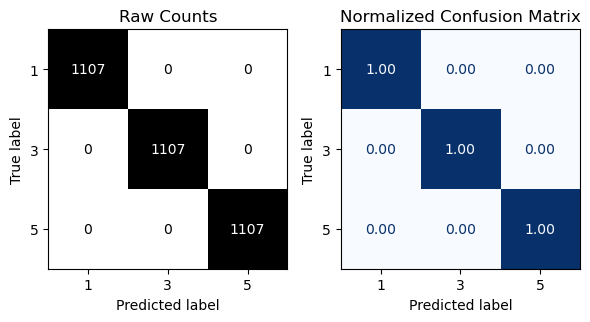


----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           1       0.61      0.81      0.70       569
           3       0.36      0.65      0.47       381
           5       0.96      0.80      0.87      2908

    accuracy                           0.79      3858
   macro avg       0.65      0.75      0.68      3858
weighted avg       0.85      0.79      0.81      3858



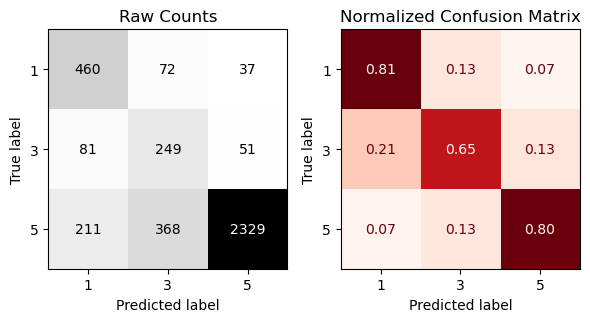

In [17]:
# Instantitate a Random Forest
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train_counts, y_train)
# Obtain evaluation metrics
evaluate_classification(clf, X_train_counts, y_train, X_test_counts, y_test)

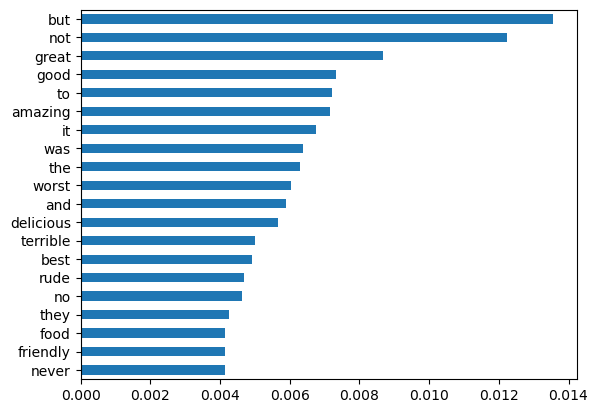

In [18]:
# Plot feature importances
importances = pd.Series(clf.feature_importances_, 
                       index =  count_vectorizer.get_feature_names_out())
importances.sort_values().tail(20).plot(kind='barh');

In [19]:
# Create a pipeline with a vectorizer and classification model.
clf_pipe = Pipeline([('vectorizer', CountVectorizer(stop_words='english')),
                     ('clf',RandomForestClassifier(random_state=42))])
clf_pipe

Pipeline(steps=[('vectorizer', CountVectorizer(stop_words='english')),
                ('clf', RandomForestClassifier(random_state=42))])

----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           1       1.00      1.00      1.00      1107
           3       1.00      1.00      1.00      1107
           5       1.00      1.00      1.00      1107

    accuracy                           1.00      3321
   macro avg       1.00      1.00      1.00      3321
weighted avg       1.00      1.00      1.00      3321



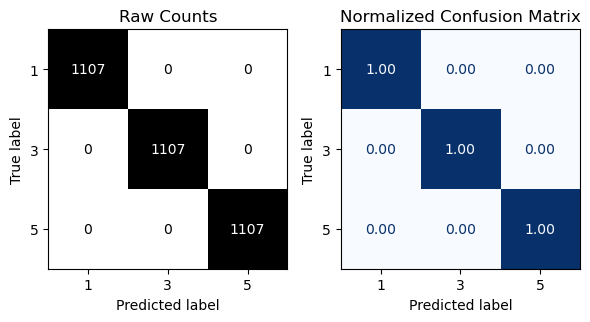


----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           1       0.65      0.82      0.72       569
           3       0.39      0.60      0.47       381
           5       0.96      0.85      0.90      2908

    accuracy                           0.82      3858
   macro avg       0.67      0.75      0.70      3858
weighted avg       0.86      0.82      0.83      3858



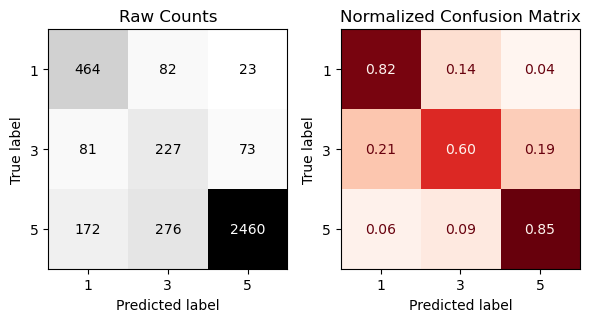

In [20]:
# Fit the model pipeline
clf_pipe.fit(X_train, y_train)
# Evaluate
evaluate_classification(clf_pipe, X_train,y_train, X_test, y_test)

<Axes: >

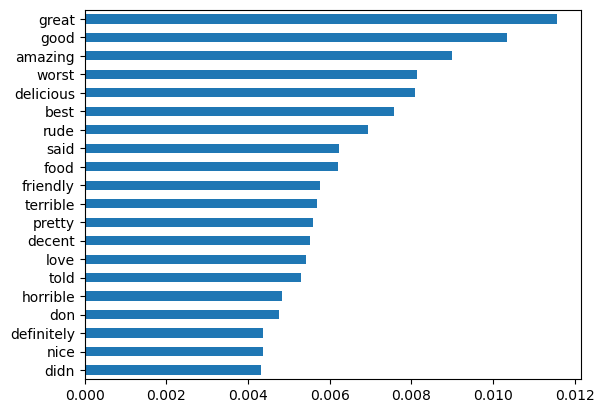

In [21]:
# Plot feature importances
importances = pd.Series(clf_pipe[-1].feature_importances_, 
                       index =  clf_pipe[0].get_feature_names_out())
importances.sort_values().tail(20).plot(kind='barh')

# Naive Bayes

In [22]:
X_train[0]

"I want to add my voice to the lack of patient care and concern exhibited by this office. Twice this year I have had tests done and it takes them forever to get me my results... unless of course I schedule an appointment then they charge me upwards of $150 and hand them to me after a cursory review. I am looking for a new doctor... can anyone recommend someone?\nBut by all means, don't waste your time here."

In [23]:
# instantiate a vectorizer with english stopwords
vectorizer = CountVectorizer(stop_words='english')

# Fit it on the data 
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           1       0.92      0.85      0.89      1107
           3       0.80      0.93      0.86      1107
           5       0.98      0.90      0.93      1107

    accuracy                           0.89      3321
   macro avg       0.90      0.89      0.89      3321
weighted avg       0.90      0.89      0.89      3321



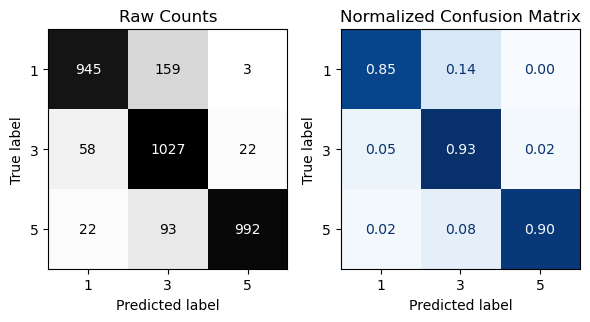


----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           1       0.62      0.75      0.68       569
           3       0.26      0.77      0.38       381
           5       0.99      0.68      0.81      2908

    accuracy                           0.70      3858
   macro avg       0.62      0.74      0.62      3858
weighted avg       0.86      0.70      0.75      3858



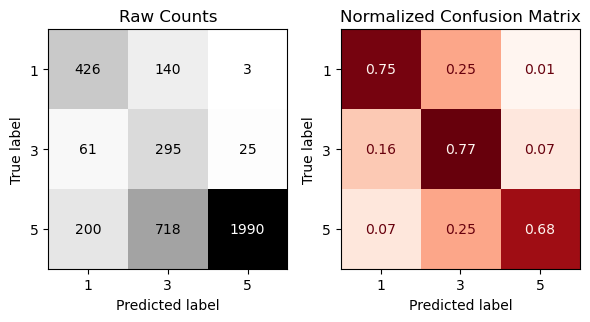

In [24]:
from sklearn.naive_bayes import MultinomialNB
clf_nb = MultinomialNB()
clf_nb.fit(X_train_vec, y_train)
evaluate_classification(clf_nb, X_train_vec,y_train, X_test_vec, y_test)

In [25]:
clf_nb.get_params()

{'alpha': 1.0, 'class_prior': None, 'fit_prior': True, 'force_alpha': 'warn'}

In [26]:
# Check class prior probabilities
class_priors = y_train.value_counts(normalize=True)
class_priors

1    0.333333
3    0.333333
5    0.333333
Name: stars, dtype: float64

In [27]:
# Define param grid
params={'alpha': [0.001, 0.1, .5, 1, 1.5, 10, 100],
        'fit_prior': [True, False]}

In [28]:
from sklearn.model_selection import GridSearchCV
#Instantiate GridSearchCV
grid_search = GridSearchCV(clf_nb, param_grid=params, n_jobs = -1, verbose = 2)
# Fit the Gridsearch on the training data
grid_search.fit(X_train_vec, y_train)

Fitting 5 folds for each of 14 candidates, totalling 70 fits


GridSearchCV(estimator=MultinomialNB(), n_jobs=-1,
             param_grid={'alpha': [0.001, 0.1, 0.5, 1, 1.5, 10, 100],
                         'fit_prior': [True, False]},
             verbose=2)

In [29]:
# Obtain the best combination directly
grid_search.best_params_

{'alpha': 0.5, 'fit_prior': True}

In [30]:
# See results of each combination of parameters
cv_results = pd.DataFrame(grid_search.cv_results_)
cv_results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,param_fit_prior,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.008196,0.004018,0.001999,6.319576e-04,0.001,True,"{'alpha': 0.001, 'fit_prior': True}",0.708271,0.709337,0.704819,0.667169,0.700301,0.697979,0.015725,9
1,0.005796,0.001166,0.001399,4.893370e-04,0.001,False,"{'alpha': 0.001, 'fit_prior': False}",0.708271,0.709337,0.704819,0.667169,0.700301,0.697979,0.015725,9
2,0.005397,0.000490,0.000999,4.623108e-07,0.1,True,"{'alpha': 0.1, 'fit_prior': True}",0.756391,0.772590,0.745482,0.727410,0.754518,0.751278,0.014793,5
3,0.004998,0.000631,0.001199,3.980408e-04,0.1,False,"{'alpha': 0.1, 'fit_prior': False}",0.756391,0.772590,0.745482,0.727410,0.754518,0.751278,0.014793,5
4,0.007395,0.004315,0.001799,7.480988e-04,0.5,True,"{'alpha': 0.5, 'fit_prior': True}",0.751880,0.789157,0.760542,0.740964,0.765060,0.761521,0.016080,1


In [31]:
# Create a list of all columns containing param_
param_cols = cv_results.columns[ cv_results.columns.str.contains('param_')]
# Limit results to the mean_test_score and parameters. Use the * operator to unpack the param_cols list 
results = cv_results.loc[:, ['mean_test_score', *param_cols]].sort_values(by = 'mean_test_score', ascending = False).round(6)
results.head()

,mean_test_score,param_alpha,param_fit_prior
4,0.761521,0.5,True
5,0.761521,0.5,False
6,0.751286,1,True
7,0.751286,1,False
2,0.751278,0.1,True


In [32]:
# Create a pipeline with a vectorizer and classification model.
clf_pipe = Pipeline([('vectorizer', CountVectorizer()),
                     ('clf',MultinomialNB())])

In [33]:
clf_pipe.get_params()

{'memory': None,
 'steps': [('vectorizer', CountVectorizer()), ('clf', MultinomialNB())],
 'verbose': False,
 'vectorizer': CountVectorizer(),
 'clf': MultinomialNB(),
 'vectorizer__analyzer': 'word',
 'vectorizer__binary': False,
 'vectorizer__decode_error': 'strict',
 'vectorizer__dtype': numpy.int64,
 'vectorizer__encoding': 'utf-8',
 'vectorizer__input': 'content',
 'vectorizer__lowercase': True,
 'vectorizer__max_df': 1.0,
 'vectorizer__max_features': None,
 'vectorizer__min_df': 1,
 'vectorizer__ngram_range': (1, 1),
 'vectorizer__preprocessor': None,
 'vectorizer__stop_words': None,
 'vectorizer__strip_accents': None,
 'vectorizer__token_pattern': '(?u)\\b\\w\\w+\\b',
 'vectorizer__tokenizer': None,
 'vectorizer__vocabulary': None,
 'clf__alpha': 1.0,
 'clf__class_prior': None,
 'clf__fit_prior': True,
 'clf__force_alpha': 'warn'}

In [34]:
param_grid = {
    "vectorizer__max_df": [ 0.75, 0.85, 0.95],
    'vectorizer__min_df': [ 2, 3, 4 ], 
    "vectorizer__max_features": [None, 500, 1000, 2000],
    "vectorizer__ngram_range": [(1, 1), (1, 2),(2,2)],
    "vectorizer__stop_words": [None,'english'],
    "clf__alpha": [.5, 1]
}

In [35]:
%%time
# Create grid search
grid_search = GridSearchCV(clf_pipe, param_grid, cv=3,verbose=2, n_jobs=-1)

# Fit the model
grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 432 candidates, totalling 1296 fits
CPU times: total: 8.39 s
Wall time: 3min 40s


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('vectorizer', CountVectorizer()),
                                       ('clf', MultinomialNB())]),
             n_jobs=-1,
             param_grid={'clf__alpha': [0.5, 1],
                         'vectorizer__max_df': [0.75, 0.85, 0.95],
                         'vectorizer__max_features': [None, 500, 1000, 2000],
                         'vectorizer__min_df': [2, 3, 4],
                         'vectorizer__ngram_range': [(1, 1), (1, 2), (2, 2)],
                         'vectorizer__stop_words': [None, 'english']},
             verbose=2)

In [36]:
grid_search.best_params_

{'clf__alpha': 1,
 'vectorizer__max_df': 0.75,
 'vectorizer__max_features': None,
 'vectorizer__min_df': 3,
 'vectorizer__ngram_range': (1, 2),
 'vectorizer__stop_words': None}

----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           1       0.94      0.90      0.92      1107
           3       0.90      0.94      0.92      1107
           5       0.98      0.97      0.97      1107

    accuracy                           0.94      3321
   macro avg       0.94      0.94      0.94      3321
weighted avg       0.94      0.94      0.94      3321



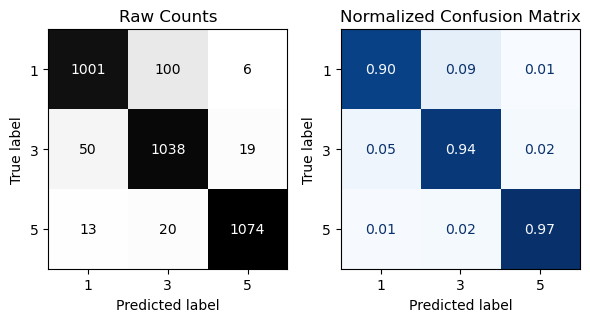


----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           1       0.65      0.79      0.72       569
           3       0.37      0.81      0.51       381
           5       0.99      0.80      0.89      2908

    accuracy                           0.80      3858
   macro avg       0.67      0.80      0.70      3858
weighted avg       0.88      0.80      0.82      3858



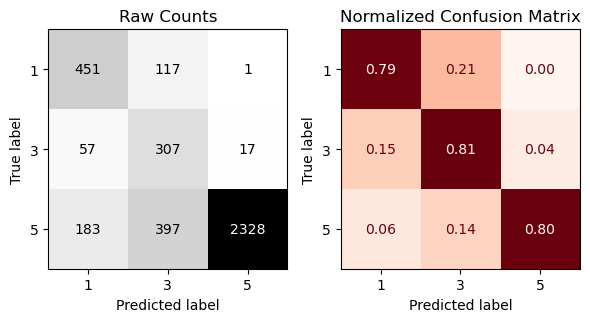

In [37]:
# Now define the best version of the model
best_model = grid_search.best_estimator_

# Predict and Evaluate with the custom function
evaluate_classification(best_model, X_train, y_train, X_test, y_test)

# Advanced Gridsearch CV

In [38]:
# Set up Pipeline to allow GridSearching different vectorizers
vect_pipe = Pipeline([('vectorizer', CountVectorizer()), # This is just a placeholder
                     ('clf',MultinomialNB())])

In [39]:
# Define a param grid with options for the vectorizer
param_grid = {
    'vectorizer': [CountVectorizer(), TfidfVectorizer()],
    'clf__alpha': [.5, 1]
}

In [40]:
# Create grid search
grid_search = GridSearchCV(vect_pipe, param_grid, cv=3, verbose=1, n_jobs=-1)
    
# Fit the model
grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 4 candidates, totalling 12 fits


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('vectorizer', CountVectorizer()),
                                       ('clf', MultinomialNB())]),
             n_jobs=-1,
             param_grid={'clf__alpha': [0.5, 1],
                         'vectorizer': [CountVectorizer(), TfidfVectorizer()]},
             verbose=1)

In [41]:
grid_search.best_params_

{'clf__alpha': 0.5, 'vectorizer': CountVectorizer()}

----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           1       0.92      0.87      0.89      1107
           3       0.83      0.93      0.88      1107
           5       0.98      0.93      0.95      1107

    accuracy                           0.91      3321
   macro avg       0.91      0.91      0.91      3321
weighted avg       0.91      0.91      0.91      3321



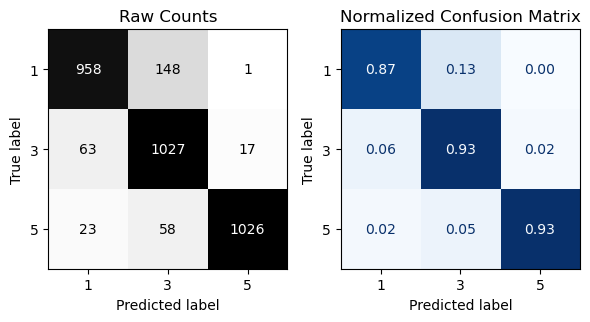


----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           1       0.63      0.76      0.69       569
           3       0.30      0.78      0.43       381
           5       0.99      0.74      0.85      2908

    accuracy                           0.75      3858
   macro avg       0.64      0.76      0.66      3858
weighted avg       0.87      0.75      0.78      3858



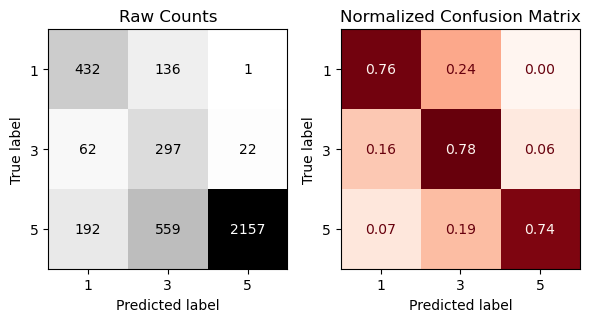

In [42]:
# Now define the best version of the model
best_model = grid_search.best_estimator_

# Predict and Evaluate with the custom function
evaluate_classification(best_model, X_train, y_train, X_test, y_test)

In [43]:
# Inlcude a parameter shared by both vectorizers (max_df)
param_grid = {
    'vectorizer': [CountVectorizer(), TfidfVectorizer()],
    "vectorizer__max_df": [0.7, 0.8, 0.9],
    'clf__alpha': [.5, 1]
}

In [44]:
# Define params to try for both vectorizers
param_grid_shared = {
    "vectorizer__max_df": [0.7, 0.8, 0.9],
    'vectorizer__min_df': [ 2, 3, 4 ], 
    "vectorizer__max_features": [None, 1000, 2000],
    "vectorizer__stop_words": [None,'english']
}

# Setting params for the count vectorizer
param_grid_count = {
    'vectorizer':[CountVectorizer()],
    **param_grid_shared
}


# Setting params for tfidf vectorizer 
param_grid_tfidf = {
    'vectorizer': [TfidfVectorizer()],
    "vectorizer__norm": ["l1", "l2"],
    "vectorizer__use_idf": [True, False],
    **param_grid_shared
}

# combine into list of params
params_combined = [param_grid_count, param_grid_tfidf]

In [45]:
%%time
# Create grid search
grid_search = GridSearchCV(vect_pipe, params_combined, cv=3, verbose=1, n_jobs=-1)
# Fit the model
grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 270 candidates, totalling 810 fits
CPU times: total: 4.95 s
Wall time: 1min 13s


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('vectorizer', CountVectorizer()),
                                       ('clf', MultinomialNB())]),
             n_jobs=-1,
             param_grid=[{'vectorizer': [CountVectorizer()],
                          'vectorizer__max_df': [0.7, 0.8, 0.9],
                          'vectorizer__max_features': [None, 1000, 2000],
                          'vectorizer__min_df': [2, 3, 4],
                          'vectorizer__stop_words': [None, 'english']},
                         {'vectorizer': [TfidfVectorizer(max_df=0.9,
                                                         max_features=2000,
                                                         min_df=3, norm='l1')],
                          'vectorizer__max_df': [0.7, 0.8, 0.9],
                          'vectorizer__max_features': [None, 1000, 2000],
                          'vectorizer__min_df': [2, 3, 4],
                          'vectorizer__norm': ['l1', 'l2'],
                          'vectorizer__stop_words': [None, 'english'],
                          'vectorizer__use_idf': [True, False]}],
             verbose=1)

In [46]:
grid_search.best_params_

{'vectorizer': TfidfVectorizer(max_df=0.9, max_features=2000, min_df=3, norm='l1'),
 'vectorizer__max_df': 0.9,
 'vectorizer__max_features': 2000,
 'vectorizer__min_df': 3,
 'vectorizer__norm': 'l1',
 'vectorizer__stop_words': None,
 'vectorizer__use_idf': True}

----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           1       0.81      0.85      0.83      1107
           3       0.79      0.81      0.80      1107
           5       0.94      0.88      0.91      1107

    accuracy                           0.85      3321
   macro avg       0.85      0.85      0.85      3321
weighted avg       0.85      0.85      0.85      3321



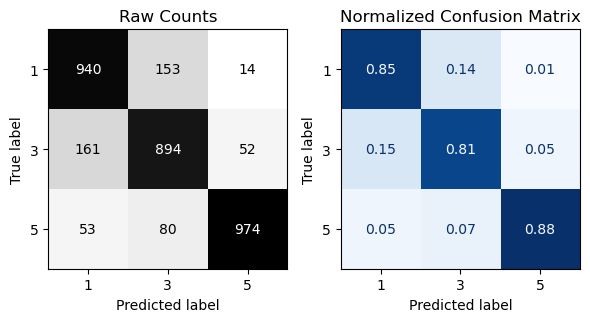


----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           1       0.64      0.81      0.71       569
           3       0.40      0.72      0.52       381
           5       0.98      0.83      0.90      2908

    accuracy                           0.82      3858
   macro avg       0.68      0.79      0.71      3858
weighted avg       0.88      0.82      0.84      3858



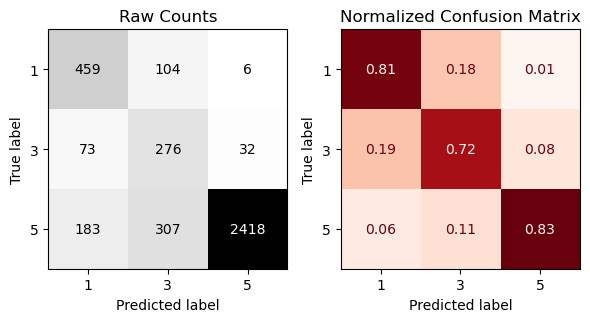

In [47]:
# Now define the best version of the model
best_model = grid_search.best_estimator_

# Predict and Evaluate with the custom function
evaluate_classification(best_model, X_train, y_train, X_test, y_test)

In [48]:
# define grid with options for which vectorizer and which classifier
param_grid = {
    'vectorizer' : [CountVectorizer(), TfidfVectorizer()],
    'clf' : [RandomForestClassifier(random_state = 42), MultinomialNB(), LogisticRegression(random_state = 42)]
}

In [49]:
%%time
# Create grid search
grid_search = GridSearchCV(vect_pipe, param_grid, cv=3, scoring = 'accuracy', verbose=1, n_jobs=-1)
# Fit the model
grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 6 candidates, totalling 18 fits
CPU times: total: 1.45 s
Wall time: 16.7 s


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('vectorizer', CountVectorizer()),
                                       ('clf', MultinomialNB())]),
             n_jobs=-1,
             param_grid={'clf': [RandomForestClassifier(random_state=42),
                                 MultinomialNB(),
                                 LogisticRegression(random_state=42)],
                         'vectorizer': [CountVectorizer(), TfidfVectorizer()]},
             scoring='accuracy', verbose=1)

In [50]:
grid_search.best_params_

{'clf': LogisticRegression(random_state=42), 'vectorizer': TfidfVectorizer()}

----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           1       0.93      0.95      0.94      1107
           3       0.92      0.91      0.91      1107
           5       0.97      0.96      0.96      1107

    accuracy                           0.94      3321
   macro avg       0.94      0.94      0.94      3321
weighted avg       0.94      0.94      0.94      3321



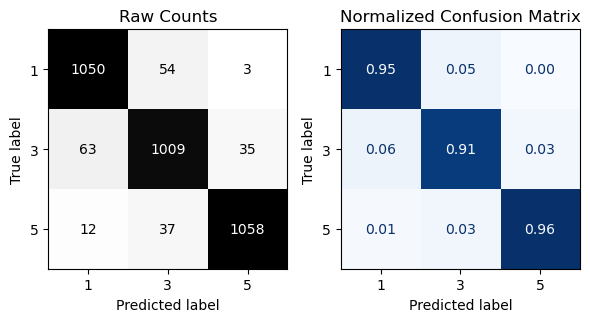


----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           1       0.71      0.84      0.77       569
           3       0.43      0.73      0.54       381
           5       0.98      0.86      0.92      2908

    accuracy                           0.84      3858
   macro avg       0.71      0.81      0.74      3858
weighted avg       0.89      0.84      0.86      3858



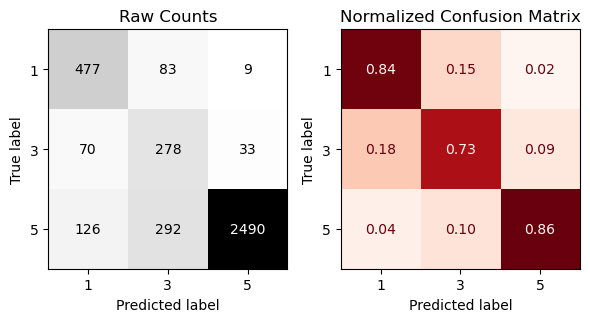

In [51]:
# Now define the best version of the model
best_model = grid_search.best_estimator_

# Predict and Evaluate with the custom function
evaluate_classification(best_model, X_train, y_train, X_test, y_test)

In [62]:
# Define parameters to tune multiple models
shared_grid = {
    'vectorizer' : [CountVectorizer(), TfidfVectorizer()]
}
param_grid_RF = {
    'clf' : [RandomForestClassifier(random_state = 42)],
    'clf__max_depth' : [5, None],
    'clf__min_samples_leaf' : [1, 2],
    **shared_grid
}

param_grid_MNB = {
    'clf' : [MultinomialNB()],
    'clf__alpha' : [.5, 1],
    **shared_grid
}

param_grid_logreg = {
    'clf': [LogisticRegression(random_state = 42)],
    'clf__C' : [.1, 1, 10, 100],
    **shared_grid
}

# combine into list of params
params_combined = [param_grid_RF, param_grid_MNB, param_grid_logreg]

In [63]:
%%time
# Create grid search
grid_search = GridSearchCV(vect_pipe, params_combined, cv=3, scoring = 'accuracy', verbose=1, n_jobs=-1)
    
    
# Fit the model
grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 20 candidates, totalling 60 fits
CPU times: total: 1.8 s
Wall time: 34.6 s


C:\Users\Rovidicus\anaconda3\envs\dojo-env\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('vectorizer', CountVectorizer()),
                                       ('clf', MultinomialNB())]),
             n_jobs=-1,
             param_grid=[{'clf': [RandomForestClassifier(random_state=42)],
                          'clf__max_depth': [5, None],
                          'clf__min_samples_leaf': [1, 2],
                          'vectorizer': [CountVectorizer(), TfidfVectorizer()]},
                         {'clf': [MultinomialNB()], 'clf__alpha': [0.5, 1],
                          'vectorizer': [CountVectorizer(), TfidfVectorizer()]},
                         {'clf': [LogisticRegression(C=10, random_state=42)],
                          'clf__C': [0.1, 1, 10, 100],
                          'vectorizer': [CountVectorizer(),
                                         TfidfVectorizer()]}],
             scoring='accuracy', verbose=1)

In [54]:
grid_search.best_params_

{'clf': LogisticRegression(C=10, random_state=42),
 'clf__C': 10,
 'vectorizer': TfidfVectorizer()}

----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           1       1.00      1.00      1.00      1107
           3       1.00      1.00      1.00      1107
           5       1.00      1.00      1.00      1107

    accuracy                           1.00      3321
   macro avg       1.00      1.00      1.00      3321
weighted avg       1.00      1.00      1.00      3321



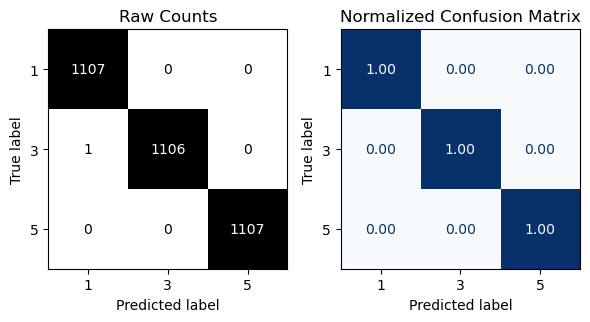


----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           1       0.74      0.84      0.79       569
           3       0.43      0.74      0.55       381
           5       0.98      0.87      0.92      2908

    accuracy                           0.85      3858
   macro avg       0.72      0.82      0.75      3858
weighted avg       0.89      0.85      0.87      3858



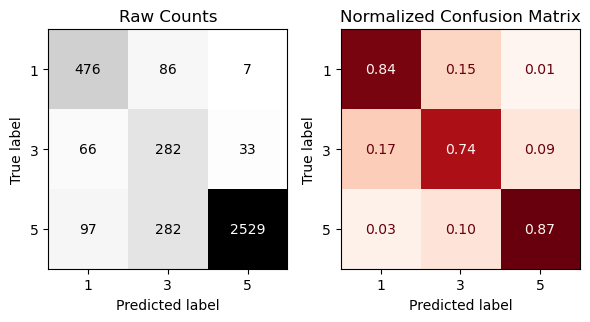

In [55]:
# Now define the best version of the model
best_model = grid_search.best_estimator_

# Predict and Evaluate with the custom function
evaluate_classification(best_model, X_train, y_train, X_test, y_test)

## Review GS Params

### Vectorizor Params

In [64]:
# Define params to try for both vectorizers
param_grid_shared = {
    "vectorizer__max_df": [0.7, 0.8, 0.9],
    'vectorizer__min_df': [ 2, 3, 4 ], 
    "vectorizer__max_features": [None, 1000, 2000],
    "vectorizer__stop_words": [None,'english']
}

# Setting params for the count vectorizer
param_grid_count = {
    'vectorizer':[CountVectorizer()],
    **param_grid_shared
}


# Setting params for tfidf vectorizer 
param_grid_tfidf = {
    'vectorizer': [TfidfVectorizer()],
    "vectorizer__norm": ["l1", "l2"],
    "vectorizer__use_idf": [True, False],
    **param_grid_shared
}

# combine into list of params
vect_params_combined = [param_grid_count, param_grid_tfidf]

### Model Params

In [66]:
# Define parameters to tune multiple models

param_grid_RF = {
    'clf' : [RandomForestClassifier(random_state = 42)],
    'clf__max_depth' : [5, None],
    'clf__min_samples_leaf' : [1, 2],
}

param_grid_MNB = {
    'clf' : [MultinomialNB()],
    'clf__alpha' : [.5, 1],
}

param_grid_logreg = {
    'clf': [LogisticRegression(random_state = 42)],
    'clf__C' : [.1, 1, 10, 100],
}

# combine into list of params
model_params_combined = [param_grid_RF, param_grid_MNB, param_grid_logreg]



### Itertools combines each

In [67]:
import itertools

paired_param_grids = list(itertools.product(vect_params_combined, model_params_combined))
paired_param_grids[0]

({'vectorizer': [CountVectorizer()],
  'vectorizer__max_df': [0.7, 0.8, 0.9],
  'vectorizer__min_df': [2, 3, 4],
  'vectorizer__max_features': [None, 1000, 2000],
  'vectorizer__stop_words': [None, 'english']},
 {'clf': [RandomForestClassifier(random_state=42)],
  'clf__max_depth': [5, None],
  'clf__min_samples_leaf': [1, 2]})

In [68]:
final_params = []
for vector_params, model_params in  paired_param_grids:
    combined = {**vector_params, **model_params}
    final_params.append(combined)
final_params[0]

{'vectorizer': [CountVectorizer()],
 'vectorizer__max_df': [0.7, 0.8, 0.9],
 'vectorizer__min_df': [2, 3, 4],
 'vectorizer__max_features': [None, 1000, 2000],
 'vectorizer__stop_words': [None, 'english'],
 'clf': [RandomForestClassifier(random_state=42)],
 'clf__max_depth': [5, None],
 'clf__min_samples_leaf': [1, 2]}

In [69]:
%%time
# Create grid search
grid_search = GridSearchCV(vect_pipe, final_params, cv=3, scoring = 'accuracy', verbose=1, n_jobs=-1)
    
    
# Fit the model
grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 2700 candidates, totalling 8100 fits
CPU times: total: 51.3 s
Wall time: 35min 36s


C:\Users\Rovidicus\anaconda3\envs\dojo-env\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('vectorizer', CountVectorizer()),
                                       ('clf', MultinomialNB())]),
             n_jobs=-1,
             param_grid=[{'clf': [RandomForestClassifier(random_state=42)],
                          'clf__max_depth': [5, None],
                          'clf__min_samples_leaf': [1, 2],
                          'vectorizer': [CountVectorizer()],
                          'vectorizer__max_df': [0.7, 0.8, 0.9],
                          'vectorizer__max_features': [None, 1000, 2000],
                          'vectori...
                         {'clf': [LogisticRegression(C=100, random_state=42)],
                          'clf__C': [0.1, 1, 10, 100],
                          'vectorizer': [TfidfVectorizer(max_df=0.7, min_df=4,
                                                         norm='l1')],
                          'vectorizer__max_df': [0.7, 0.8, 0.9],
                          'vectorizer__max_features': [None, 1000, 2000],
                          'vectorizer__min_df': [2, 3, 4],
                          'vectorizer__norm': ['l1', 'l2'],
                          'vectorizer__stop_words': [None, 'english'],
                          'vectorizer__use_idf': [True, False]}],
             scoring='accuracy', verbose=1)